In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [39]:
import pandas as pd
df = pd.read_csv("C:/Users/cgplugs/Documents/python practise/BERT/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [40]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [41]:
#there is an imbalance in the dataset. in order to balance it. We are using downsampling method.

spam_df = df[df['Category'] == 'spam']
spam_df.shape

ham_df = df[df['Category'] == 'ham']
ham_df.shape

desamp_ham = ham_df.sample(spam_df.shape[0])
desamp_ham.shape

df_balanced = pd.concat([spam_df, desamp_ham])

df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [42]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
2146,spam,Sunshine Hols. To claim ur med holiday send a ...,1
1655,ham,"Wishing you and your family Merry ""X"" mas and ...",0
3157,ham,Long time. You remember me today.,0
2513,ham,"Hiya , have u been paying money into my accoun...",0
4028,ham,"Yes, princess. Are you going to make me moan?",0
1406,ham,K..k..any special today?,0
183,ham,ok. I am a gentleman and will treat you with d...,0
4106,ham,Jus finish my lunch on my way home lor... I to...,0
4166,spam,"Dear Voucher Holder, To claim this weeks offer...",1
1215,ham,I'll text now! All creepy like so he won't thi...,0


In [112]:
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify = df_balanced['spam'])
X_train.head()

4649               We are okay. Going to sleep now. Later
5366    A £400 XMAS REWARD IS WAITING FOR YOU! Our com...
3423    Freemsg: 1-month unlimited free calls! Activat...
4882                          When/where do I pick you up
4901    ou are guaranteed the latest Nokia Phone, a 40...
Name: Message, dtype: object

In [113]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-768-a-12/versions/2",
    trainable=True)

In [114]:
def get_sent_embd(sent):
    t = preprocessor(sent) 
    return encoder(t)["pooled_output"]
    
get_sent_embd([
    "$500 discount. Hurry up",
    "Ravi, are you up for a volley ball game tomorrow"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[ 0.10399851, -0.00899155,  0.9611012 , ...,  0.19794455,
        -0.01090231,  0.2357476 ],
       [ 0.06636112,  0.3050319 ,  0.9957009 , ...,  0.29148403,
        -0.09468994, -0.19486263]], dtype=float32)>

In [115]:
# BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessor(text_input)
outputs = encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [116]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_14 (KerasLayer)    {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [117]:
mert = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = mert)

In [118]:
model.fit(X_train, y_train)

35/35 [==============================] - 386s 11s/step - loss: 0.3514 - accuracy: 0.9107 - precision: 0.9197 - recall: 0.9000


In [101]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 161s 5s/step - loss: 8.9561e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 2/10
35/35 [==============================] - 172s 5s/step - loss: 2.4556e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 3/10
35/35 [==============================] - 306s 9s/step - loss: 5.4807e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/10
35/35 [==============================] - 946s 27s/step - loss: 1.3915e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/10
35/35 [==============================] - 275s 8s/step - loss: 1.2465e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 6/10
35/35 [==============================] - 407s 12s/step - loss: 1.3023e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 7/10
35/35 [==============================] - 2129s 62s/step - loss: 1.3548e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 8/10
35/35

In [119]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

12/12 [==============================] - 42s 3s/step


In [120]:
import numpy as np
y_pred= np.where(y_pred > 0.5,1,0)
y_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,

In [121]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm

array([[177,  10],
       [  6, 181]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

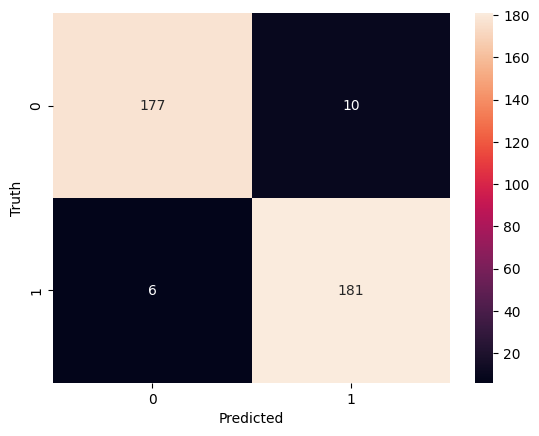

In [122]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       187
           1       0.95      0.97      0.96       187

    accuracy                           0.96       374
   macro avg       0.96      0.96      0.96       374
weighted avg       0.96      0.96      0.96       374



In [124]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.98482245],
       [0.95760673],
       [0.9875978 ],
       [0.00852017],
       [0.00541827]], dtype=float32)

In [110]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])